<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

##### 7th exercise: <font color="#C70039">Work with Variational Autoencoders (Generative Model)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Mathis Loevenich
* Date:   06.12.2022
* Matr. No.: 11157363 

<img src="https://miro.medium.com/max/848/1*6uuK7GpIbfTb-0chqFwXXw.png" style="float: center;" width="400">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
A Variational Autoencoder (VAE), instead of compressing its input image into a fixed code in the latent space (as the classic autoencoder does), turns the input image into the parameters of a statistical distribution: a mean and a variance.

This implies / imputes that the input image has been generated by a statistical process and that the randomness of this process should be taken into accounting during encoding and decoding. 

The VAE then uses the mean and variance parameters to randomly sample one element of that distribution, and decodes that element back to the original input. 

The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.


---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
    * try to understand each single step.
4. the notebooks code, especially keras is sometimes utilized a bit cumbersome. Try to optimize the code where you feel necessary.
5. experiment with different hyperparameters (search for the keyword 'task')
6. describe the three different loss curve plots. What do they show? Is this what you expected?
7. the main task is to visualize the latent space, the encoder has created. If you set high dimensions for the latent dim you can use T_SNE (plot 4).
8. describe the latent space with respect to its structure. Is this what you expected from a VAE?
---------------------------------

### VAEs
This code demonstrates a VAE using the MNIST dataset.
Just like a regular autoencoder a VAE returns an array (image) of same dimensions as the input but variation can be introduced by tweaking the so-called latent vector.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers, models, losses, metrics, optimizers
from   tensorflow.keras.datasets import mnist
from sklearn.manifold import TSNE

In [2]:
# class 'latent_sampling', which subclasses layers.Layer.
# The class should perform the reparameterisation trick in its .call() method.

'''---------------------------------------------------------------------------'''
# Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
# epsilon = N(0,1), a unit normal with same dims as mean and variance
'''---------------------------------------------------------------------------'''
class latent_sampling(layers.Layer):
    
  def call(self, z_mean, z_log_var):
    tf.keras.layers.Layer(trainable = True)
    self.batch = tf.shape(z_mean)[0]
    self.dim = tf.shape(z_mean)[1]
    self.epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
    self.z =  z_mean + self.epsilon * tf.exp(z_log_var * 0.5)
    
    return self.z

In [3]:
### The 'VAE' Class. 
### The __init__ method—which will set up the layers and submodels—and the call() method.

class VAE(tf.keras.Model):
    """
    A Keras Model that implements a Variational Autoencoder. Model properties
    should include the encoder and decoder models, a sampling layer, and the
    number of latent variables in the encoded space.
    """
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        """
        Take in model properties and assign them to self.
        """
        self.latent_dim = latent_dim
        self.encoder = self.create_encoder()
        self.sampling = latent_sampling()
        self.decoder = self.create_decoder()
        
    def create_encoder(self):
        encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
        encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
        encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
        encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)
        z_mean = layers.Dense(units = self.latent_dim, name = 'latent_mean')(encoder_dense_2)
        z_log_var  = layers.Dense(units = self.latent_dim, name = 'latent_log_var')(encoder_dense_2)

        encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')
        return encoder
    
    def create_decoder(self):
        decoder_input = layers.Input(shape=(self.latent_dim,), dtype='float32')
        decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
        decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
        decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
        img_out = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)

        decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
        return decoder
        
    def encode(self, x):
        """
        Method that applies the encoder model to input data. Returns the mean
        and ln(variance) of the encoded variables.
        """
        mean, logvar = self.encoder(x)
        return mean, logvar

    def decode(self, z):
        """
        Method that applies the decoder model to a set of encoded variables.
        Returns the generated images from the encoded data.
        """
        x_hat = self.decoder(z)
        return x_hat

    def kl_loss(self, mean, logvar):
        """
        Method that calculates the Kullback-Liebler divergence between the
        posterier distribution, N(mean, variance), and the prior, N(0,1).
        Can be added to the model as a loss or metric, using self.add_loss and
        self.add_metric
        """

        # Calculate the element wise KL divergence
        kl = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        # Sum up the divergence of all the variables in each data sample
        kl = tf.reduce_sum(kl, axis=1)
        # Average the divergence across all samples in the batch
        kl = tf.reduce_mean(kl)
        return kl

    def call(self, inputs):
        """
        Apply the encoder, sampling layer and decoder to the input data. Add
        the kl divergence to the model losses and metrics. Return the generated
        image.
        """
        z_mean, z_log_var = self.encoder(inputs)
        sampled_output = self.sampling(z_mean, z_log_var)
        output = self.decoder(sampled_output)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        self.add_metric(self.kl_loss(z_mean, z_log_var), name = 'kl_loss_metric')
        return output

In [4]:
# Modified loss function for the model. The standard binary cross entropy
# takes a mean over all pixels in all images, but the VAE needs the
# reconstruction loss to be the sum of the pixel-wise losses, averaged over
# samples in the batch. Otherwise the reconstruction loss is becoming too small.

def recon_loss(y_true, y_pred):
    loss = tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred),axis=(1, 2))
    return loss

In [5]:
# Create the VAE model, using your encoder and decoder models. 
# Compile the model with appropriate optimizer settings, losses and metrics.
'''
(TASK: don't be afraid to experiment with different settings here (e.g. latent_dim))
'''
autoencoder = VAE(latent_dim = 2)

# Default learning rate, optimizer = nAdam.
autoencoder.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,
                    metrics = [recon_loss, 'accuracy'])

In [6]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Function to preprocess the data 
def preprocessing(image):
    image =  tf.expand_dims(image, -1)
    image =  tf.image.random_flip_left_right(image)
    image  = tf.image.convert_image_dtype(image, 'float32')

    return image, image

# Slice off the training data
dataset = tf.data.Dataset.from_tensor_slices(x_train)

# Preparing the data for training 
final_dataset = dataset.shuffle(1000).batch(64, drop_remainder=True).map(preprocessing)

11490434/11490434 [==============================] - 2s 0us/step


### Train the model
Train the model on the images from the training set until the losses converge.
"history = model.fit" allows for storing the training and validation losses in a dictionary so they can be visualized later.

In [7]:
history = autoencoder.fit(final_dataset, batch_size = 256, epochs =30)
history.history.keys()  

Epoch 1/30
937/937 [==============================] - 16s 10ms/step - loss: 179.8189 - recon_loss: 174.8331 - accuracy: 0.7930 - kl_loss_metric: 4.9858
Epoch 2/30
937/937 [==============================] - 7s 7ms/step - loss: 165.6059 - recon_loss: 160.2308 - accuracy: 0.7941 - kl_loss_metric: 5.3751
Epoch 3/30
937/937 [==============================] - 7s 7ms/step - loss: 161.8216 - recon_loss: 156.1748 - accuracy: 0.7945 - kl_loss_metric: 5.6468
Epoch 4/30
937/937 [==============================] - 7s 7ms/step - loss: 159.6263 - recon_loss: 153.8228 - accuracy: 0.7947 - kl_loss_metric: 5.8036
Epoch 5/30
937/937 [==============================] - 7s 7ms/step - loss: 158.0511 - recon_loss: 152.1206 - accuracy: 0.7949 - kl_loss_metric: 5.9304
Epoch 6/30
937/937 [==============================] - 7s 7ms/step - loss: 156.8726 - recon_loss: 150.8321 - accuracy: 0.7951 - kl_loss_metric: 6.0406
Epoch 7/30
937/937 [==============================] - 7s 7ms/step - loss: 155.9396 - recon_loss: 1

dict_keys(['loss', 'recon_loss', 'accuracy', 'kl_loss_metric'])

### Visualize the results (plot 1)
Create plots that show the losses and metrics, the reconstruction quality of
the trained network, and the generative quality of the network. 

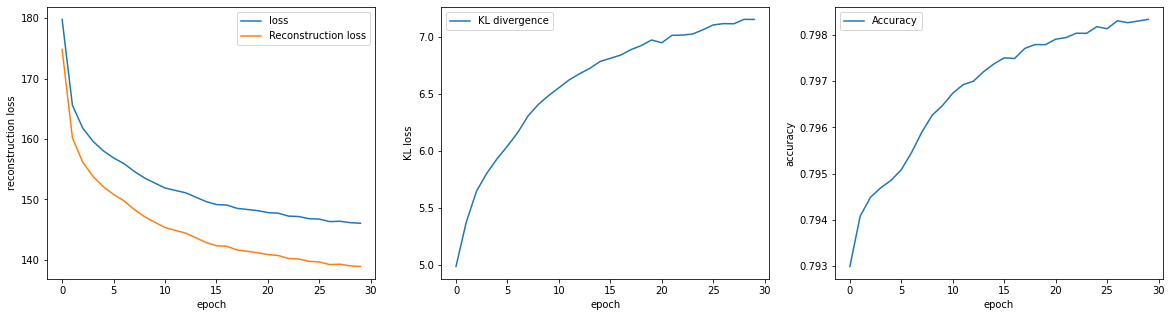

In [8]:
f, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(history.history['loss'], label = 'loss')
ax[0].plot(history.history['recon_loss'], label = 'Reconstruction loss')
ax[0].set_ylabel('reconstruction loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.history['kl_loss_metric'], label = 'KL divergence')
ax[1].set_ylabel('KL loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].plot(history.history['accuracy'], label = 'Accuracy')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].legend()

plt.show()

## Description:
- Loss:
    - Difference between the predicted output and the true output. 
- Reconstruction loss:
    - This is the mean squarred error (MSE) of predicted output and initial input
- KL divergence:
    - measures the divergence of one probability distribution from another
    - meaning it gives information about how much information is lost if we approximate one probability distribution by another
- Accuracy:
    - The number or correct True assessments over the total number of assessments.

### Prediction of test data (plot 2)

313/313 [==============================] - 1s 2ms/step


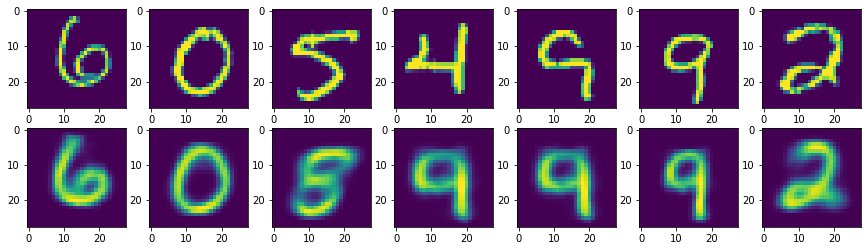

In [9]:
predict = autoencoder.predict(x_test/255.)
f, ax = plt.subplots(2, 7, figsize = (15,4))

# Testing the reconstruction quality of the network using the Test Images 
for i in range(7):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(predict[i+100,:,:,0])

### Testing the generative quality of the network (plot 3)

1/1 [==============================] - 0s 12ms/step


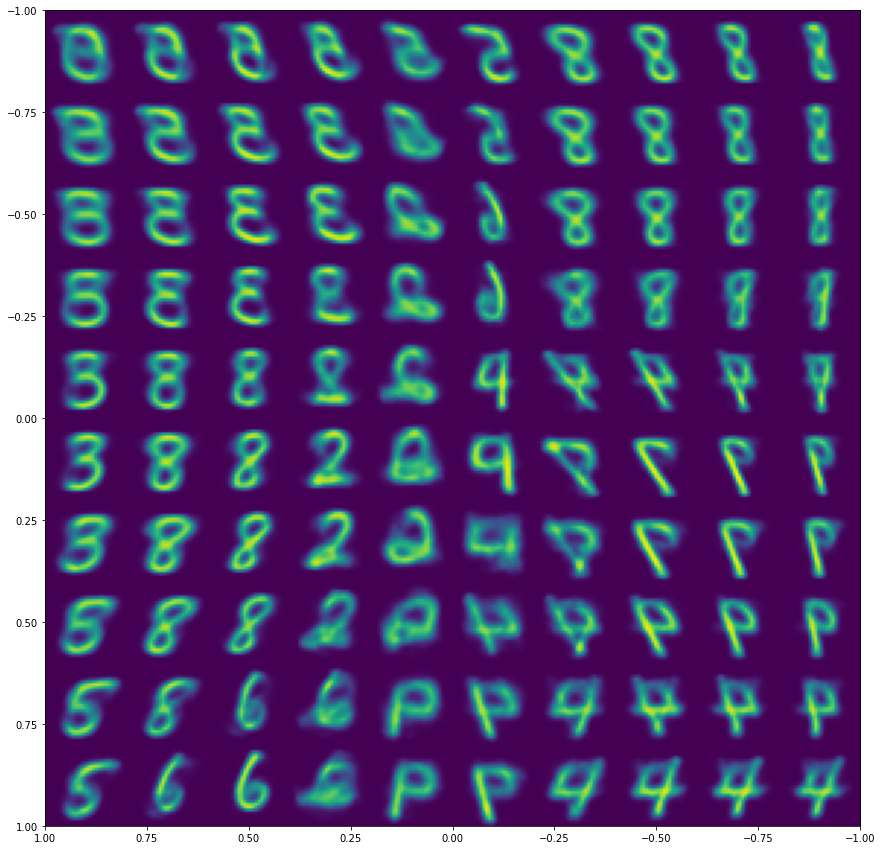

In [10]:
x_axis = np.linspace(-1, 1, 10)
y_axis = np.linspace(-1, 1, 10)
figure = np.zeros((28 * 10, 28 * 10))

# loop through each number for decoding
for i_x, x in enumerate(x_axis):
    for i_y, y in enumerate(y_axis):
        latent = np.array([[x, y]])
        #print(latent)
        generated_image = autoencoder.decoder.predict(latent)[0] # decode the numbers
        figure[i_x*28:(i_x+1)*28, i_y*28:(i_y+1)*28,] = generated_image[:,:,-1]

plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[1,-1,1,-1])
plt.show()

### Task: Visualize the latent space (if latent_dim > 2 then by using T_SNE) (plot 4)
#### Describe the latent space with respect to its structure. 

Remember: t-SNE is stochastic and therefore the results may appear slightly different every time it is re-run. So don't worry.


In [11]:
colors = ["red", "green", "blue", "black", "yellow", "orange", "purple", "cyan", "magenta", "grey"]

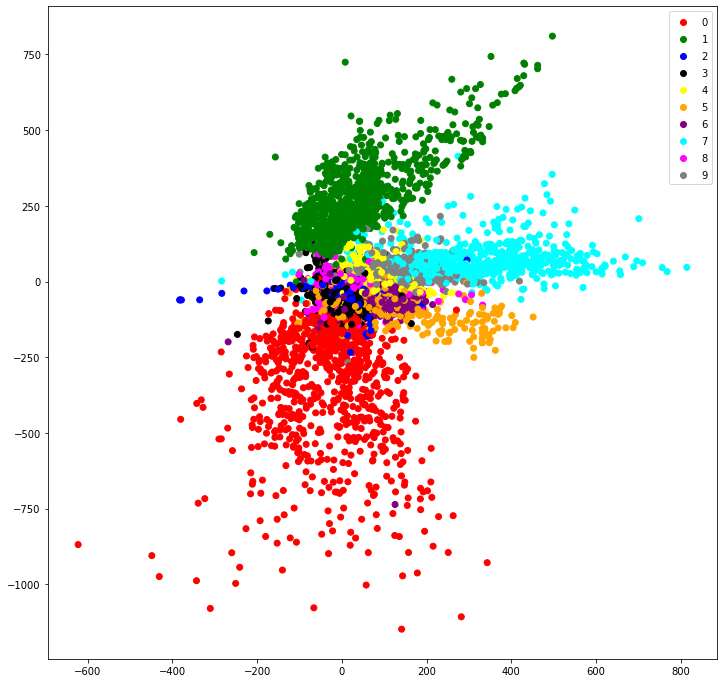

In [12]:
encoded_imgs, log_var = autoencoder.encode(x_test) # encode

from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(12,12))
scatter = plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test, cmap=ListedColormap(colors))
plt.legend(*scatter.legend_elements())
plt.show()

# Findings:

### First attempt with latent_dim=10:

    - I have tried it with latent_dim = 10 and TSNE but you can't really see clusters here. Maybe due to the dimensionality reduction of tsne or because latent_dim=10 is too high to actually encode the features correctly with epochs=30
    
### Second attempt with latent_dim=4:
    - also the result was not much better and taking a closer look I've recognized that the latent_dim (2) was hardcoded into the decoder and encoder, hence I rewrote the code to set the latent_space dynamically.
    
### Third attempt with latent_dim=4:
    - Now with the new setup I'll try again to create better results

In [13]:
autoencoder2 = VAE(latent_dim = 4)
# Default learning rate, optimizer = nAdam.
autoencoder2.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,metrics = [recon_loss, 'accuracy'])

In [14]:
history = autoencoder2.fit(final_dataset, batch_size = 256, epochs =30)

Epoch 1/30
937/937 [==============================] - 8s 7ms/step - loss: 161.2319 - recon_loss: 152.8979 - accuracy: 0.7954 - kl_loss_metric: 8.3341
Epoch 2/30
937/937 [==============================] - 7s 7ms/step - loss: 142.5204 - recon_loss: 133.1201 - accuracy: 0.7991 - kl_loss_metric: 9.4004
Epoch 3/30
937/937 [==============================] - 7s 7ms/step - loss: 137.3321 - recon_loss: 127.5085 - accuracy: 0.8004 - kl_loss_metric: 9.8237
Epoch 4/30
937/937 [==============================] - 7s 7ms/step - loss: 134.5572 - recon_loss: 124.4840 - accuracy: 0.8012 - kl_loss_metric: 10.0732
Epoch 5/30
937/937 [==============================] - 7s 7ms/step - loss: 132.6707 - recon_loss: 122.4111 - accuracy: 0.8018 - kl_loss_metric: 10.2597
Epoch 6/30
937/937 [==============================] - 7s 7ms/step - loss: 131.1347 - recon_loss: 120.7328 - accuracy: 0.8023 - kl_loss_metric: 10.4020
Epoch 7/30
937/937 [==============================] - 7s 7ms/step - loss: 129.9579 - recon_loss: 

In [15]:
z_mean, log_var = autoencoder2.encode(x_test) # encode

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


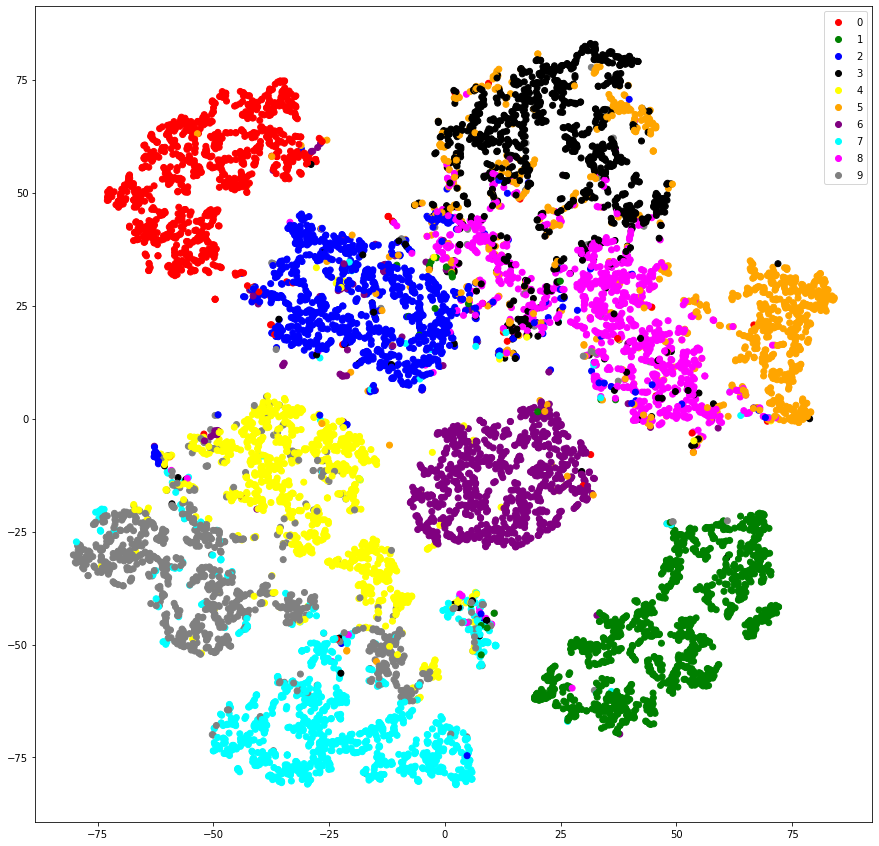

In [16]:
# Create a t-SNE model
model = TSNE(n_components = 2)

# Transform the data
X_2d = model.fit_transform(z_mean)

fig, ax = plt.subplots(figsize=(15,15))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_test, cmap=ListedColormap(colors))
plt.legend(*scatter.legend_elements())
plt.show()

### Now try one more time with latent_dim=10:

In [22]:
autoencoder3 = VAE(latent_dim = 10)
# Default learning rate, optimizer = nAdam.
autoencoder3.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,metrics = [recon_loss, 'accuracy'])

In [23]:
history = autoencoder3.fit(final_dataset, batch_size = 256, epochs =30)

Epoch 1/30
937/937 [==============================] - 8s 7ms/step - loss: 144.6332 - recon_loss: 130.3380 - accuracy: 0.8015 - kl_loss_metric: 14.2952
Epoch 2/30
937/937 [==============================] - 7s 8ms/step - loss: 118.9628 - recon_loss: 101.2966 - accuracy: 0.8078 - kl_loss_metric: 17.6662
Epoch 3/30
937/937 [==============================] - 7s 8ms/step - loss: 114.1270 - recon_loss: 95.8867 - accuracy: 0.8090 - kl_loss_metric: 18.2404
Epoch 4/30
937/937 [==============================] - 7s 7ms/step - loss: 111.5039 - recon_loss: 92.9540 - accuracy: 0.8097 - kl_loss_metric: 18.5500
Epoch 5/30
937/937 [==============================] - 7s 7ms/step - loss: 109.8145 - recon_loss: 91.0409 - accuracy: 0.8101 - kl_loss_metric: 18.7736
Epoch 6/30
937/937 [==============================] - 7s 7ms/step - loss: 108.5600 - recon_loss: 89.6383 - accuracy: 0.8104 - kl_loss_metric: 18.9217
Epoch 7/30
937/937 [==============================] - 7s 7ms/step - loss: 107.5583 - recon_loss: 8

In [24]:
z_mean, log_var = autoencoder3.encode(x_test) # encode

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


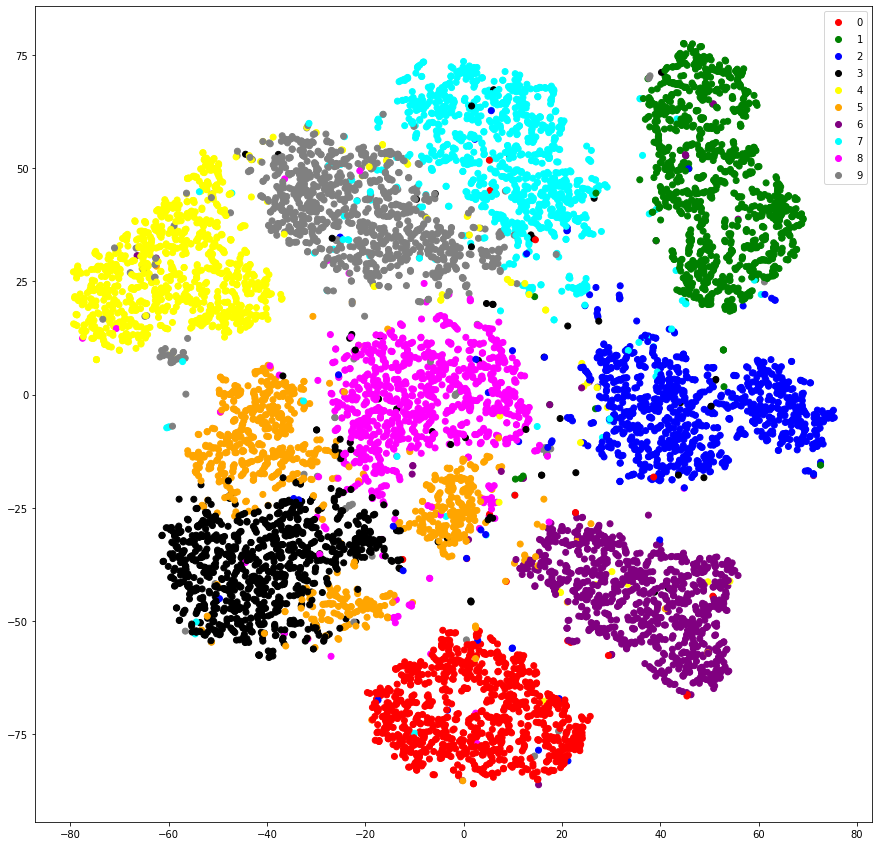

In [25]:
# Create a t-SNE model
model = TSNE(n_components = 2)

# Transform the data
X_2d = model.fit_transform(z_mean)

fig, ax = plt.subplots(figsize=(15,15))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_test, cmap=ListedColormap(colors))
plt.legend(*scatter.legend_elements())
plt.show()

# Key Findings:

- Variational Autoencoders allow to have similar input create the same kind of encoding into the latent space which means they are relatively close to each other in the meaning of euclidean distance and can form clusters.
- This is a very nice way for XAI to explain what the model is doing and how the clustering can look like.
- It also shows which kind of object the model struggles with to identify correctly. 
- It makes it easier to see which of the inputs the model is more and less capable of reconstructing hence it can be used as classifier or a dimensionality reduction
- Compared to the simple autoencoder, it can therefore also be used for image generation

- We can observe here with latent_dim=10 that the model is reasonable good in clustering numbers like: 0, 1, 2 and 6 but it struggles more with other numbers as there are many more outliers.
- The reason for this is obviously that hand writen numbers can sometimes be hard to read even for a human.
- It might also depend on the quality and how often a number is representend in the dataset